# Machine Learning Engineer Nanodegree
## Unsupervised Learning
# &#x1F4D1; &nbsp; P3: Creating Customer Segments

## Getting Started
### Dataset
In this project, we will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.
### Resources
- [Scikit-learn](http://scikit-learn.org/stable/index.html)
- [Seaborn](http://seaborn.pydata.org/index.html)

### Code Library

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: ghostwhite;} 
a {color: #5a8bbd; font-family: 'Roboto';} 
h1 {color: #1b2c45; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #1b2c45; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #5a8bbd;}      
div.output_stderr pre {background-color: ghostwhite;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #1b2c45; background: ghostwhite; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                

In [2]:
hide_code = ''
#########################################
### IMPORT LIBRARIES FOR THIS PROJECT ###
#########################################
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.cm as cm

from IPython.display import display, SVG, HTML
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
%matplotlib inline

################################
### ADD EXTRA LIBRARIES HERE ###
################################

import seaborn as sns
cmap = sns.cubehelix_palette(2, start=0.1, rot=-.25, as_cmap=True)
import pygal
from pygal.style import BlueStyle
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

In [3]:
hide_code
# https://github.com/udacity/machine-learning/blob/master/projects/customer_segments/visuals.py

def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    plt.style.use('seaborn-pastel')
    fig, ax = plt.subplots(figsize = (18,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights", fontsize=12)
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (18,10))

    # Color map
    cmap = sns.cubehelix_palette(2, start=0.1, rot=-.25, as_cmap=True)

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=250);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=120, color='black');
    # Plot transformed sample points 
        ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
                   s = 150, linewidth = 4, color = 'black', marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data\n\
    Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross", fontsize=20);

def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''
    fig, ax = plt.subplots(figsize = (18, 8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='slategrey', edgecolors='1b2c45', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=20)

    ax.set_xlabel("Dimension 1", fontsize=12)
    ax.set_ylabel("Dimension 2", fontsize=12)
    ax.set_title("PC plane with original feature projections.", fontsize=20);
    return ax
    
def channel_results(reduced_data, outliers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
    Data is labeled by "Channel" and cues added for student-selected sample data
    '''

    # Check that the dataset is loadable
    try:
        full_data = pd.read_csv("customers.csv")
    except:
        print ("Dataset could not be loaded. Is the file missing?")
        return False

    # Create the Channel DataFrame
    channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
    channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
    labeled = pd.concat([reduced_data, channel], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (18,10))

    # Color map
    cmap = sns.cubehelix_palette(2, start=0.1, rot=-.25, as_cmap=True)

    # Color the points based on assigned Channel
    labels = ['Hotel/Restaurant/Cafe', 'Retailer']
    grouped = labeled.groupby('Channel')
    for i, channel in grouped:   
        channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
   
    # Plot transformed sample points   
    for i, sample in enumerate(pca_samples):
        ax.scatter(x = sample[0], y = sample[1], \
                   s = 230, linewidth = 3, color = 'black', 
                   marker = 'o', facecolors = 'none');
        ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), 
                   alpha = 1, s=200, color='black');

    # Set plot title
    ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled", fontsize=20);

## Data Exploration
In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others. We will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

The dataset is composed of six important product categories: `'Fresh'`, `'Milk'`, `'Grocery'`, `'Frozen'`, `'Detergents_Paper'`, and `'Delicatessen'`. Consider what each category represents in terms of products we could purchase.
### Data Loading

In [94]:
hide_code
# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print ("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print ("Dataset could not be loaded. Is the dataset missing?")

# Display a description of the dataset
display(data.describe())

Wholesale customers dataset has 440 samples with 6 features each.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


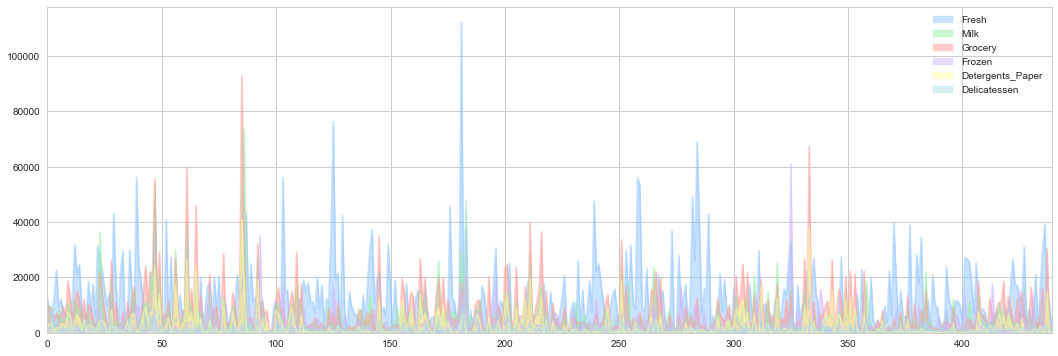

In [95]:
hide_code
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-pastel')
data.plot.area(stacked=False, figsize=(18, 6));

### Implementation:  Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [6]:
hide_code
# Select three indices of your choice you wish to sample from the dataset
indices = [23,25,27]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print ("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,26373,36423,22019,5154,4337,16523
1,16165,4230,7595,201,4003,57
2,14276,803,3045,485,100,518


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
### Answer 1
I have built a plot for comparing the feature values with the means and a heatmap to visualize for each customer the spending amount per feature in percentages.

In [8]:
hide_code
line = pygal.Line(fill=False, 
                  style=BlueStyle(opacity='.3', 
                                  colors=('#1b2c45', 'steelblue', 'darkcyan', 'red'),
                                  background='transparent'), 
                  height=400)
line.title = 'Samples of the Wholesale Customers Dataset'
line.x_labels = list(samples)
line.add('C0', list(samples.loc[0]))
line.add('C1', list(samples.loc[1]))
line.add('C2', list(samples.loc[2]))
line.add('Mean', list(data.mean()), color='red')
line.render_to_file('samples.svg')

HTML("""<figure><embed type="image/svg+xml" src="samples.svg"/></figure>""")

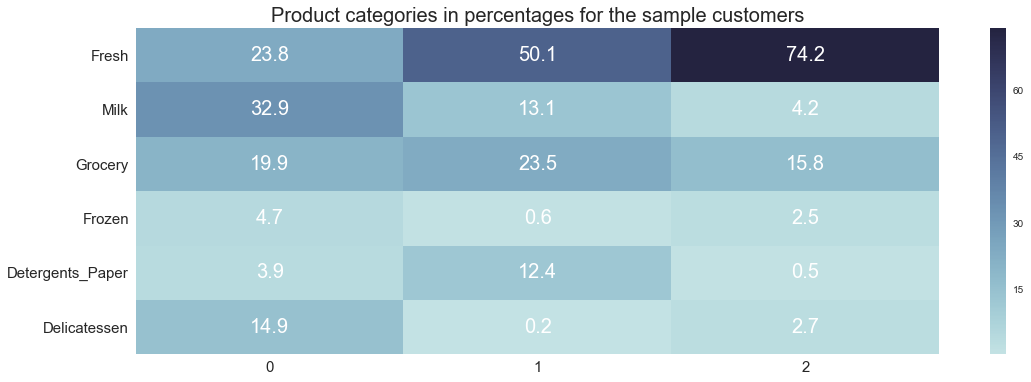

In [9]:
hide_code
plt.figure(figsize=(18,6))
p_samples = samples.iloc[:].T.apply(lambda x: 100.0 * x / x.sum())
sns.heatmap(p_samples, cmap=cmap, annot=True, 
            annot_kws={"color":"White", "size": 20}, fmt='.1f')
plt.title("Product categories in percentages for the sample customers", fontsize=20)
plt.xticks(ha='center', fontsize=15)
plt.yticks(fontsize=15);

- Customer C0: Food-oriented supermarket (the wide range of products with big values).
- Customer C1: Market for the nearest neighborhood (the main feature is 'Fresh').
- Customer C2: Vegetarian cafe or restaurant (the most important categories are 'Fresh' and 'Grocery').

### Implementation:  Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, we will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of our choice using the `DataFrame.drop` function.
 - Use `sklearn.model_selection.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as our target label. 
   - Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

#### Experiment with the Feature `'Delicatessen'`

In [10]:
hide_code
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Delicatessen', axis = 1)
target = data['Delicatessen']
new_data_target = pd.concat([new_data, target], axis = 1)
# Display the correlation table for the given feature
print ("The correlation table for the choosen feature 'Delicatessen'")
pearson = new_data_target.corr(method='pearson')
corr_with_delicatessen = pearson.iloc[-1][:-1]
corr_with_delicatessen[abs(corr_with_delicatessen).argsort()[::-1]]

The correlation table for the choosen feature 'Delicatessen'


Milk                0.406368
Frozen              0.390947
Fresh               0.244690
Grocery             0.205497
Detergents_Paper    0.069291
Name: Delicatessen, dtype: float64

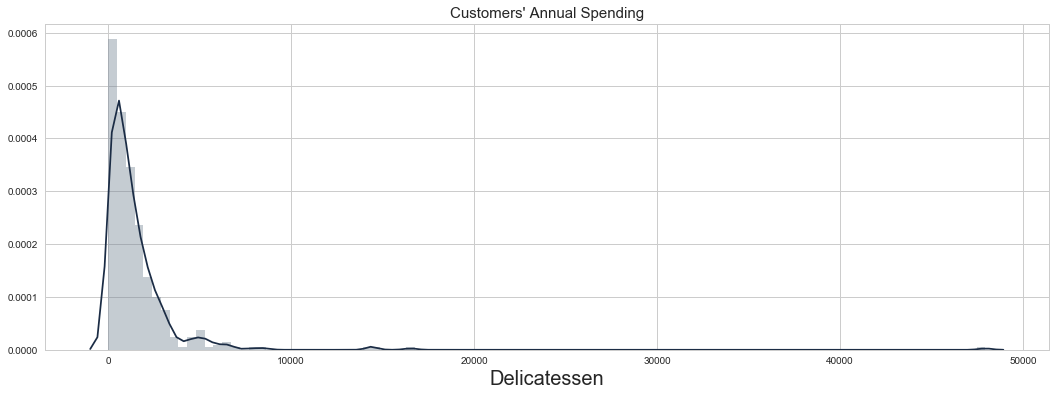

In [12]:
hide_code
plt.figure(figsize=(18, 6))
sns.distplot(target, color='#1b2c45', bins=100, hist_kws={'color':'SlateGrey'})
plt.xlabel("Delicatessen", fontsize=20)
plt.title("Customers' Annual Spending", fontsize=15);

In [13]:
hide_code
# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size = 0.25, random_state = 1)
# Success
print ("Training and testing split was successful.")

# Create a decision tree regressor and random forest regressor fit them to the training set
regressor1 = DecisionTreeRegressor(random_state=1)
regressor1.fit(X_train, y_train)
regressor2 = RandomForestRegressor(random_state=1)
regressor2.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score1 = regressor1.score(X_test, y_test)
print("Decision Tree Regressor. The score of the prediction using the testing set is {}.".format(score1))
score2 = regressor2.score(X_test, y_test)
print("Random Forest Regressor. The score of the prediction using the testing set is {}.".format(score2))

Training and testing split was successful.
Decision Tree Regressor. The score of the prediction using the testing set is -0.4291251956585451.
Random Forest Regressor. The score of the prediction using the testing set is -0.4255431805608154.


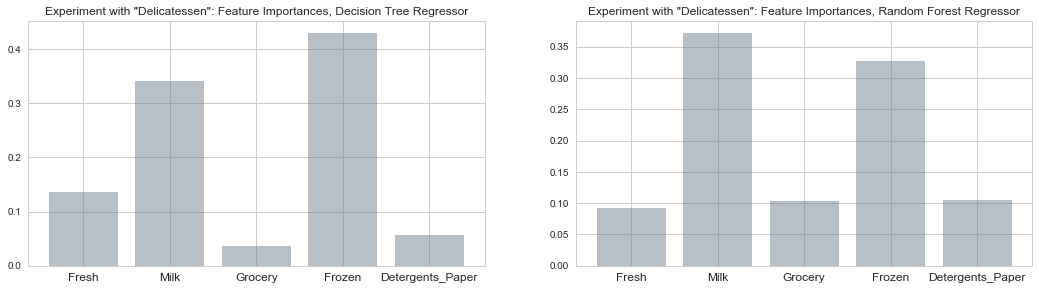

In [14]:
hide_code
D1 = dict(zip(new_data, regressor1.feature_importances_))
D2 = dict(zip(new_data, regressor2.feature_importances_))
plt.figure(figsize=(18,4.5))

plt.subplot(121)
plt.bar(range(len(D1)), D1.values(), alpha=0.5, color='slategrey', align='center')
plt.xticks(range(len(D1)), D1.keys(), fontsize=12)
plt.title('Experiment with "Delicatessen": Feature Importances, Decision Tree Regressor')

plt.subplot(122)
plt.bar(range(len(D2)), D2.values(), alpha=0.5, color='slategrey', align='center')
plt.xticks(range(len(D2)), D2.keys(), fontsize=12)
plt.title('Experiment with "Delicatessen": Feature Importances, Random Forest Regressor');

#### Experiment with the Feature `'Grocery'`

In [15]:
hide_code
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Grocery', axis = 1)
target = data['Grocery']
new_data_target = pd.concat([new_data, target], axis = 1)
# Display the correlation table for the given feature
print ("The correlation table for the choosen feature 'Grocery'")
pearson = new_data_target.corr(method='pearson')
corr_with_grocery = pearson.iloc[-1][:-1]
corr_with_grocery[abs(corr_with_grocery).argsort()[::-1]]

The correlation table for the choosen feature 'Grocery'


Detergents_Paper    0.924641
Milk                0.728335
Delicatessen        0.205497
Frozen             -0.040193
Fresh              -0.011854
Name: Grocery, dtype: float64

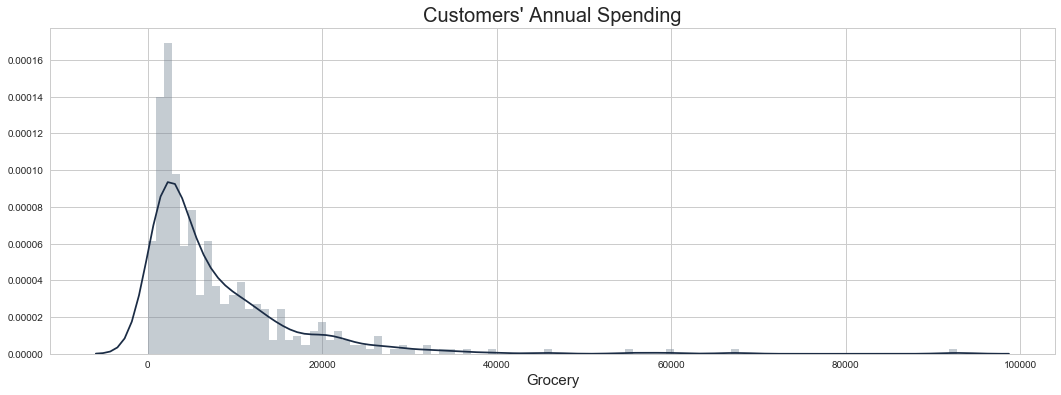

In [16]:
hide_code
plt.figure(figsize=(18,6))
sns.distplot(target, color='#1b2c45', bins=100, hist_kws={'color':'SlateGrey'})
plt.xlabel("Grocery", fontsize=15)
plt.title("Customers' Annual Spending", fontsize=20);

In [17]:
hide_code
# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size = 0.25, random_state = 1)
# Success
print ("Training and testing split was successful.")

# Create a decision tree regressor and random forest regressor fit them to the training set
regressor1 = DecisionTreeRegressor(random_state=1)
regressor1.fit(X_train, y_train)
regressor2 = RandomForestRegressor(random_state=1)
regressor2.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score1 = regressor1.score(X_test, y_test)
print("Decision Tree Regressor. The score of the prediction using the testing set is {}.".format(score1))
score2 = regressor2.score(X_test, y_test)
print("Random Forest Regressor. The score of the prediction using the testing set is {}.".format(score2))

Training and testing split was successful.
Decision Tree Regressor. The score of the prediction using the testing set is 0.7957683115761958.
Random Forest Regressor. The score of the prediction using the testing set is 0.8454561694902754.


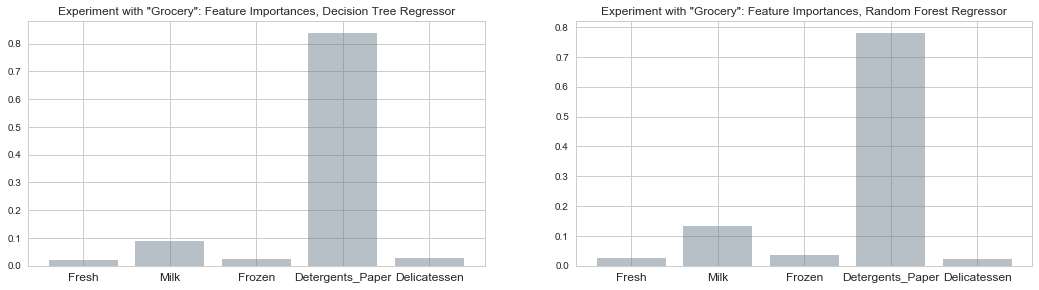

In [18]:
hide_code
D1 = dict(zip(new_data, regressor1.feature_importances_))
D2 = dict(zip(new_data, regressor2.feature_importances_))
plt.figure(figsize=(18,4.5))

plt.subplot(121)
plt.bar(range(len(D1)), D1.values(), alpha=0.5, color='slategrey', align='center')
plt.xticks(range(len(D1)), D1.keys(), fontsize=12)
plt.title('Experiment with "Grocery": Feature Importances, Decision Tree Regressor')

plt.subplot(122)
plt.bar(range(len(D2)), D2.values(), alpha=0.5, color='slategrey', align='center')
plt.xticks(range(len(D2)), D2.keys(), fontsize=12)
plt.title('Experiment with "Grocery": Feature Importances, Random Forest Regressor');

### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
### Answer 2
I have chosen `'Grocery'`. In this case, the reported score for predictions is 0.7958, and the feature has a strong correlation with at least two others (`'Detergents_Paper'` and `'Milk'`). Therefore, it was easy to predict `'Grocery'` values by applying a simple regressor (Decision Tree). An ensemble regressor (Random Forest) demonstrates better results and confirms the assumptions.

It means also that this feature is not so important for identifying spending habits of customers, and these strong relationships between variables make possible to run the procedure of dimensionality reduction.

The experiment with `'Delicatessen'` demonstrates the fact that it's hard to predict the values of this feature based on others, so `'Delicatessen'` is important for custom clustering. 

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If we found that the feature we attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if we believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. 

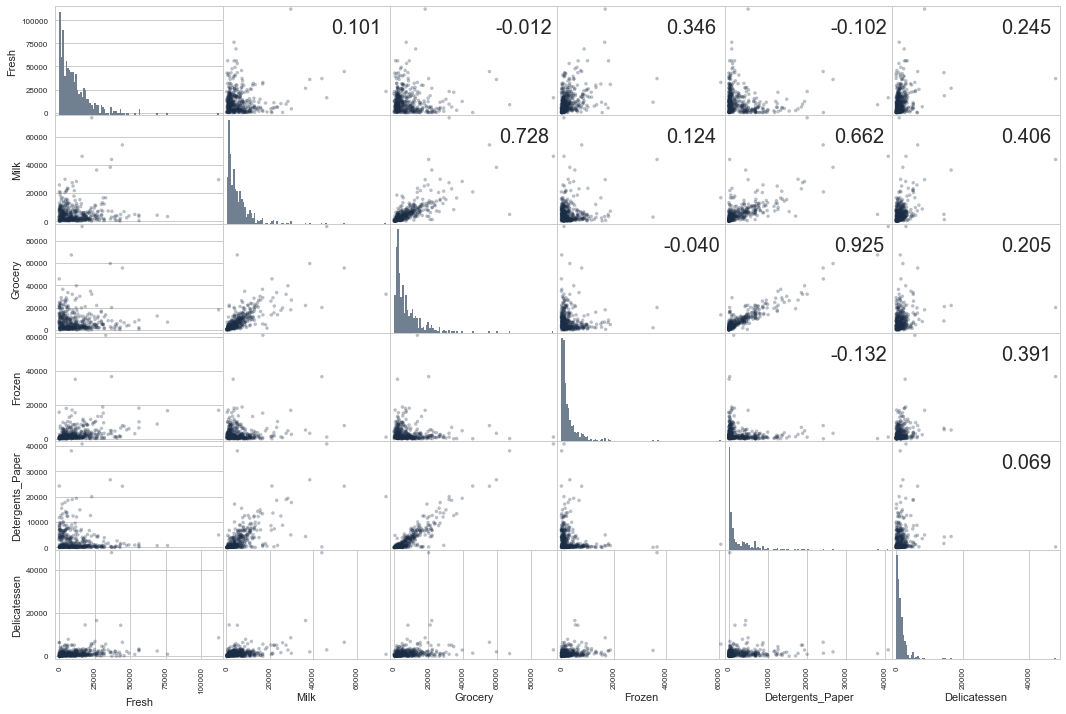

In [19]:
hide_code
# Produce a scatter matrix for each pair of features in the data
axes = pd.scatter_matrix(data, alpha = 0.3, figsize = (18,12), diagonal = 'hist',
                         c='#1b2c45', hist_kwds={'color':'SlateGrey', 'bins':100})
corr = data.corr().as_matrix()
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), fontsize=20,
                        xycoords='axes fraction', ha='center', va='center');

In [20]:
hide_code
pearson = data.corr(method='pearson')
print ("Pearson correlation coefficients")
pearson

Pearson correlation coefficients


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?* 
### Answer 3
The highest degree of correlation has the pair `'Grocery'-'Detergents_Paper'` (0.9246). The scatter plots demonstrate it very clearly. There are some pairs else with a well-detectable correlation: `'Milk'-'Grocery'` and `'Milk'-'Detergents_Paper'`.

These facts confirm the thoughts about the relevance of the feature we attempted to predict.

We should also note that the features is not normally distributed. But the log-normal distribution looks very similar with our features. I have created the random example of the log-normal distribution for visual comparing.

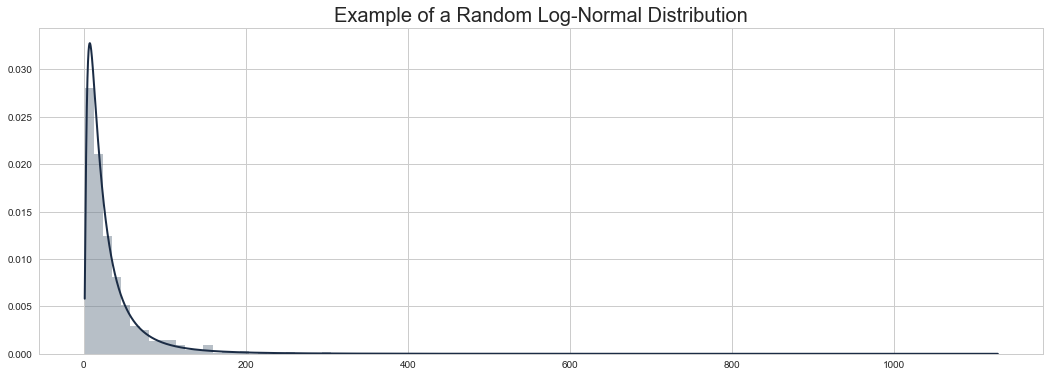

In [21]:
hide_code
plt.figure(figsize=(18,6))
mu, sigma = 3., 1. 
s = np.random.lognormal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 100, normed=True, align='mid', alpha=0.5, color='slategrey')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='#1b2c45')
plt.axis('tight')
plt.title('Example of a Random Log-Normal Distribution', fontsize=20);

## Data Preprocessing
In this section, we will preprocessing the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation:​ Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

Now we will do the following steps:

 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

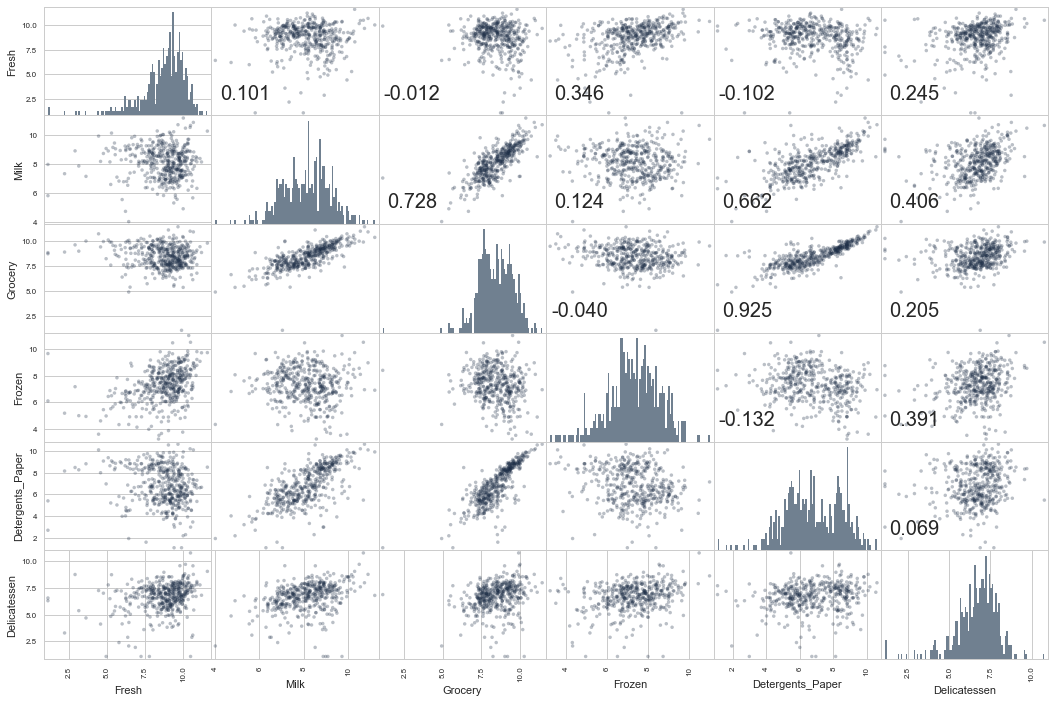

In [22]:
hide_code
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
axes = pd.scatter_matrix(log_data, alpha = 0.3, figsize = (18,12), diagonal = 'hist',
                         c='#1b2c45', hist_kwds={'color':'SlateGrey', 'bins':100})
corr = data.corr().as_matrix()
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.2, 0.2), fontsize=20,
                        xycoords='axes fraction', ha='center', va='center');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features we may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

In [23]:
hide_code
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.180096,10.502956,9.999661,8.547528,8.374938,9.712509
1,9.690604,8.349957,8.935245,5.303305,8.294799,4.043051
2,9.566335,6.688355,8.021256,6.184149,4.605170,6.249975


In [24]:
hide_code
pearson_log = log_data.corr(method='pearson')
print ("Pearson correlation coefficients")
pearson_log

Pearson correlation coefficients


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,-0.019834,-0.132713,0.383996,-0.155871,0.255186
Milk,-0.019834,1.000000,0.758851,-0.055316,0.677942,0.337833
Grocery,-0.132713,0.758851,1.000000,-0.164524,0.796398,0.235728
Frozen,0.383996,-0.055316,-0.164524,1.000000,-0.211576,0.254718
Detergents_Paper,-0.155871,0.677942,0.796398,-0.211576,1.000000,0.166735
Delicatessen,0.255186,0.337833,0.235728,0.254718,0.166735,1.000000


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

So the next steps are the following:

 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.


In [25]:
hide_code
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print ("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = [65,66,75,128,154]
print("Data outliers: '{}'".format(outliers))

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Data outliers: '[65, 66, 75, 128, 154]'


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 
### Answer 4
Five data points [65, 66, 75, 128, 154] can be detected as outliers for more than one feature. It's confirmed by another method with a heatmap in the original data.

I think it needs to remove them from the data. When we apply k-means the results can be distorted by outliers: clusters are constructed with calculations of cluster-centers as the averages of all data points from this cluster, so outliers can have a great influence. If we do not remove outliers from the dataset, they can form additional artificial clusters for the outliers which can get some data points from the real clusters.

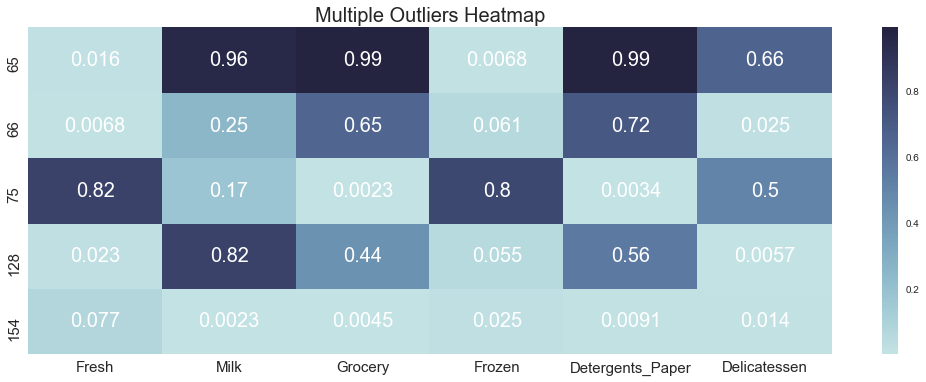

In [26]:
hide_code
percentiles = data.rank(pct=True)
percentiles = percentiles.iloc[outliers]

plt.figure(figsize=(18,6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Multiple Outliers Heatmap', fontsize=20)
sns.heatmap(percentiles, annot=True, cmap=cmap, annot_kws={'color':'White', 'size':'20'});

## Feature Transformation
In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

The next steps are the following:

 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

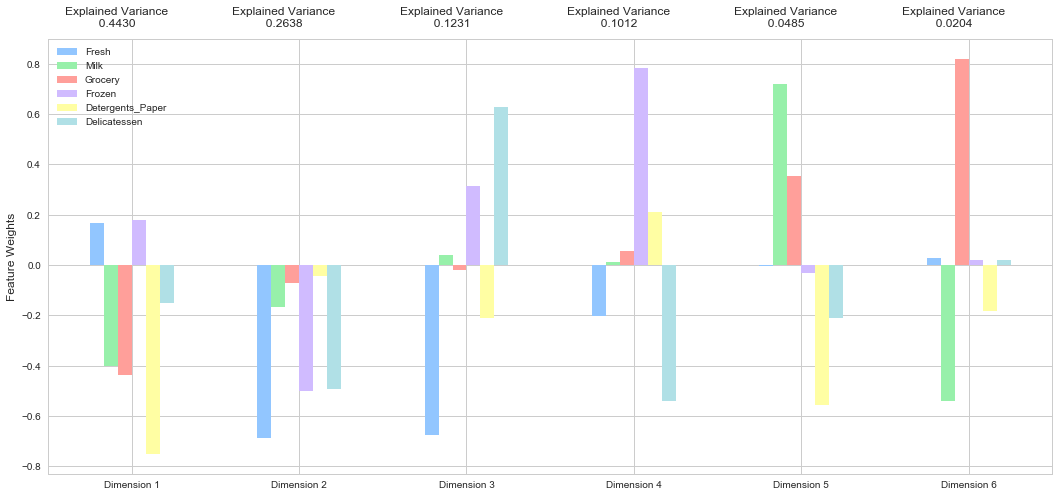

In [27]:
hide_code
# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=len(good_data.keys())).fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_result = pca_results(good_data, pca);

In [28]:
hide_code
pca_result

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941
Dimension 3,0.1231,-0.6774,0.0402,-0.0195,0.3150,-0.2117,0.6286
Dimension 4,0.1012,-0.2043,0.0128,0.0557,0.7854,0.2096,-0.5423
Dimension 5,0.0485,-0.0026,0.7192,0.3554,-0.0331,-0.5582,-0.2092
Dimension 6,0.0204,0.0292,-0.5402,0.8205,0.0205,-0.1824,0.0197


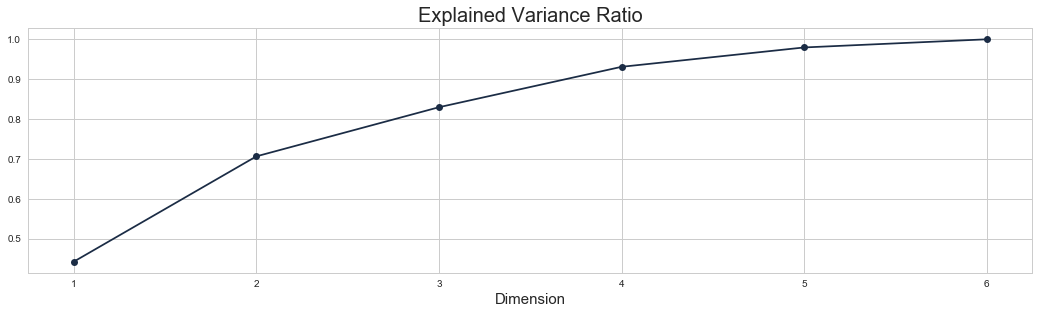

In [29]:
hide_code
plt.figure(figsize=(18,4.5))
plt.plot(np.arange(1, 7), np.cumsum(pca.explained_variance_ratio_), '-o', c='#1b2c45')
plt.xlabel('Dimension', fontsize=15)
plt.title('Explained Variance Ratio', fontsize=20);

### Question 5
*How much variance in the data is explained **in total** by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
### Answer 5
**Dimension 1**: features `'Milk', 'Grocery', 'Detergents_Paper'` have the highest influence, so it seems like a regular household spending on retail goods in supermarkets. We noted in the previous section that these three features are highly correlated.

**Dimension 2**: features `'Fresh', 'Frozen', 'Delicatessen'` are the most important, so it can be a spending for restaurants and cafes with a wide spectrum of the menu.

**Dimension 3**: features `'Fresh', 'Frozen', 'Delicatessen'` are the most important also but they have different directions, so it can be a spending on retail goods in the nearest stores and markets.

**Dimension 4**: features `'Fresh', 'Frozen', 'Delicatessen'` are the most important also but 'Frozen' has the highest influence, so it can be a spending for restaurants and cafes with a special spectrum of the menu (fast food, for example).

The first four dimensions best represent in terms of customer spending because they explained the main part of the spending variance.

In [30]:
hide_code
print ("The first and second principal components explained {}%".format((0.4430 + 0.2638)*100))
print ("The first four principal components explained {}%".format((0.4430 + 0.2638 + 0.1231 + 0.1012)*100))

The first and second principal components explained 70.67999999999999%
The first four principal components explained 93.11%


### PCA Observation
Let us have a look how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with our initial interpretation of the sample points.

In [31]:
hide_code
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_result.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.8096,-3.6459,1.0567,-0.5186,0.6999,-0.1811
1,-1.2292,1.5540,-3.2462,0.0043,0.1124,-0.0697
2,2.4162,0.6069,-0.7652,-1.3209,0.1614,0.8089


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

The next steps are the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [32]:
hide_code
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Dimensionality Reduction Observation
Let's see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [33]:
hide_code
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.8096,-3.6459
1,-1.2292,1.5540
2,2.4162,0.6069


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components ( in this case `Dimension 1` and  `Dimension 2` ). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

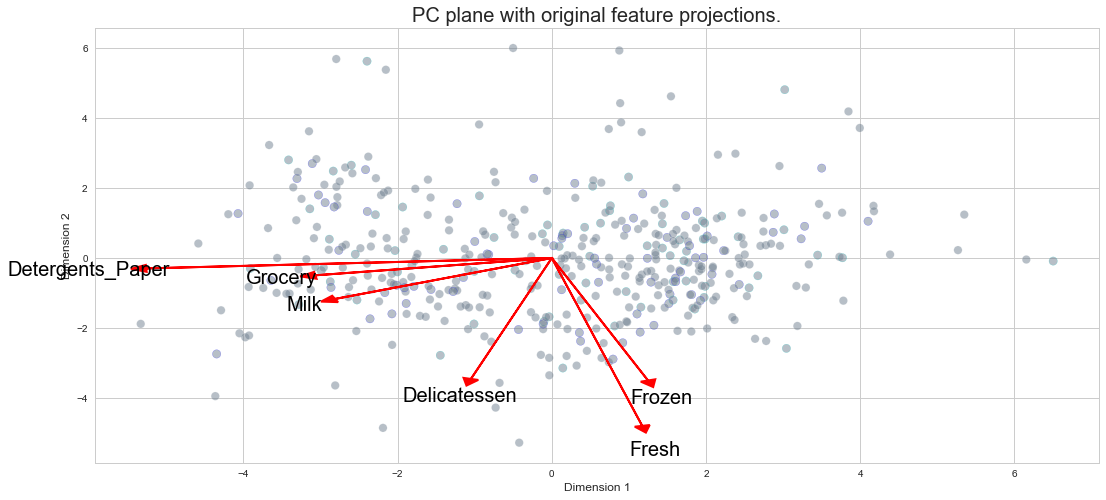

In [34]:
hide_code
# Create a biplot
biplot(good_data, reduced_data, pca);

### Biplot Observation
Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

*From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the `pca_results` plot we obtained earlier?*

The features `'Milk', 'Grocery', 'Detergents_Paper'` are most strongly correlated with the first component (their projections are very close to the horizontal line). The features `'Fresh', 'Frozen', 'Delicatessen'` are correlated with the second component but not so strongly (their projections are close to the vertical line).

The `pca_results` plot displays exactly the same observations.

## Clustering

In this section, we will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. We will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*
### Answer 6
The advantages of the K-Means clustering in comparing with the Gaussian Mixture Model clustering are speed and simplicity. K-means only maintains cluster centers (linearly correlated with the feature numbers) and it will be much faster in model training.

The advantages of the Gaussian Mixture Model are a "soft" classification (indicated how likely the concrete data point belongs to the certain cluster) and a good performance with different data distributions.

Theoretically, the Gaussian Mixture Model can do the job better thanks to its soft classification, but the K-Means also can predict correctly without additional complexity of the model. This project is not so large so we can try to apply both just to compare algorithms in action.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that we expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

Now we need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 
### Answer 7
I have printed scores for the K-Means clustering and the Gaussian Mixture Model. We can see the highest scores in case of 2 clusters for both algorithms. So it should be our choice.

In [35]:
hide_code
for n in list(range(2,12)):
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.cluster_centers_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    print ("For number of clusters = {}, the silhouette_score is : {}".format(n, score))

For number of clusters = 2, the silhouette_score is : 0.42628101546910835
For number of clusters = 3, the silhouette_score is : 0.3968909264498051
For number of clusters = 4, the silhouette_score is : 0.33125652580240916
For number of clusters = 5, the silhouette_score is : 0.34999779752629756
For number of clusters = 6, the silhouette_score is : 0.36324113418847664
For number of clusters = 7, the silhouette_score is : 0.3631341458142936
For number of clusters = 8, the silhouette_score is : 0.3494461633832999
For number of clusters = 9, the silhouette_score is : 0.3598790146053614
For number of clusters = 10, the silhouette_score is : 0.35380305302618237
For number of clusters = 11, the silhouette_score is : 0.35038839752102513


In [36]:
hide_code
for n in list(range(2,12)):
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer2 = GMM(n_components=n, covariance_type='full').fit(reduced_data)

    # Predict the cluster for each data point
    preds2 = clusterer2.predict(reduced_data)

    # Find the cluster centers
    centers2 = clusterer2.means_

    # Predict the cluster for each transformed sample data point
    sample_preds2 = clusterer2.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score2 = silhouette_score(reduced_data, preds2, metric='mahalanobis')
    print ("For number of clusters = {}, the silhouette_score is : {}".format(n, score2))

For number of clusters = 2, the silhouette_score is : 0.3706341419906261
For number of clusters = 3, the silhouette_score is : 0.3620557146625406
For number of clusters = 4, the silhouette_score is : 0.2631598536221327
For number of clusters = 5, the silhouette_score is : 0.20028264319388459
For number of clusters = 6, the silhouette_score is : 0.27912974721879086
For number of clusters = 7, the silhouette_score is : 0.28300382972608784
For number of clusters = 8, the silhouette_score is : 0.2901802835833453
For number of clusters = 9, the silhouette_score is : 0.17696425627448056
For number of clusters = 10, the silhouette_score is : 0.1847581767100842
For number of clusters = 11, the silhouette_score is : 0.14408394768212718


We also can run the speed comparison for the K-Means clustering and the Gaussian Mixture Model.

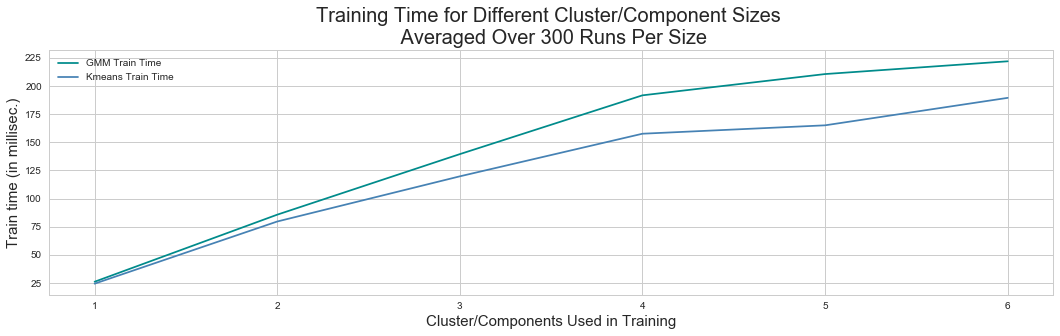

In [37]:
hide_code
n = 300
k = 6

kmeans_train_times = []
for k in range(1, 7):
    cum_time = 0.
    for i in range(n):
        start = time.time()
        KMeans(n_clusters=k).fit(reduced_data)
        cum_time += (time.time() - start)

    train_time = cum_time / n
    kmeans_train_times.append([k, train_time])

km_df = pd.DataFrame(kmeans_train_times, columns=['KM_Clusters', 'KM_Time'])

gmm_train_times = []
for k in range(1, 7):
    cum_time = 0.
    for i in range(n):
        start = time.time()
        GMM(n_components=k).fit(reduced_data)
        cum_time += (time.time() - start)

    train_time = cum_time / n
    gmm_train_times.append([k, train_time])

gmm_df = pd.DataFrame(gmm_train_times, columns=['GMM_Components', 'GMM_Time'])
times_df = km_df.join(gmm_df)

plt.figure(figsize=(18,4.5))
plt.plot(times_df.GMM_Components, times_df.GMM_Time * 1000., 
         c='darkcyan', label='GMM Train Time')
plt.plot(times_df.GMM_Components, times_df.KM_Time * 1000., 
         c='steelblue', label='Kmeans Train Time')
plt.legend(loc='best')
plt.ylabel('Train time (in millisec.)', fontsize=15)
plt.xlabel('Cluster/Components Used in Training', fontsize=15)
plt.title('Training Time for Different Cluster/Component Sizes \n Averaged Over {} Runs Per Size'\
          .format(n), fontsize=20);

### Cluster Visualization
Once we've chosen the optimal number of clusters for the clustering algorithm using the scoring metric above, we can now visualize the results. Note that, for experimentation purposes, it's useful to adjust the number of clusters for the clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters.

In [38]:
hide_code
# Apply K-means for for 2 clusters
clusterer = KMeans(n_clusters=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
sample_preds = clusterer.predict(pca_samples)
score = silhouette_score(reduced_data, preds)

K-Means


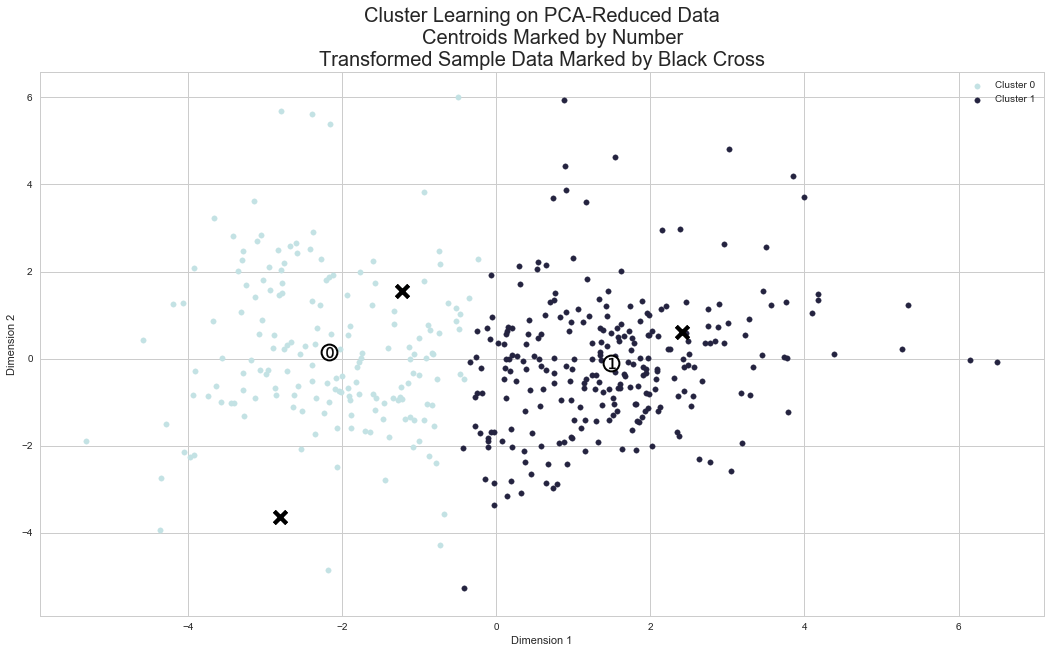

In [39]:
hide_code
# Display the results of the clustering from implementation
cluster_results(reduced_data, preds, centers, pca_samples)
print ("K-Means")

In [42]:
hide_code
# Apply Gaussian Mixture Model for 2 clusters
clusterer2 = GMM(n_components=2, covariance_type='full').fit(reduced_data)
preds2 = clusterer2.predict(reduced_data)
centers2 = clusterer2.means_
sample_preds2 = clusterer2.predict(pca_samples)
score2 = silhouette_score(reduced_data, preds2)

Gaussian Mixture Model


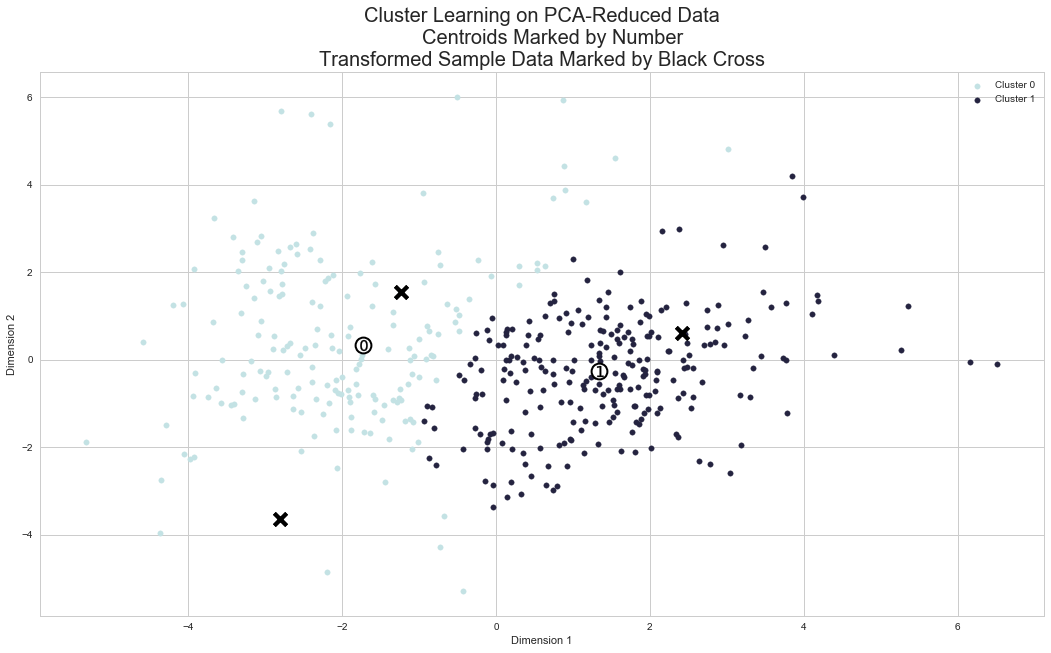

In [43]:
hide_code
# Display the results of the clustering from implementation
cluster_results(reduced_data, preds2, centers2, pca_samples)
print('Gaussian Mixture Model')

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

It's time for the next steps:

 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.

In [61]:
hide_code
print ("Data Means")
display(pd.DataFrame(np.mean(data)).T)

Data Means


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455


In [68]:
hide_code
print ("K-Means")
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

K-Means


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4005.0,7900.0,12104.0,952.0,4561.0,1036.0
Segment 1,8867.0,1897.0,2477.0,2088.0,294.0,681.0


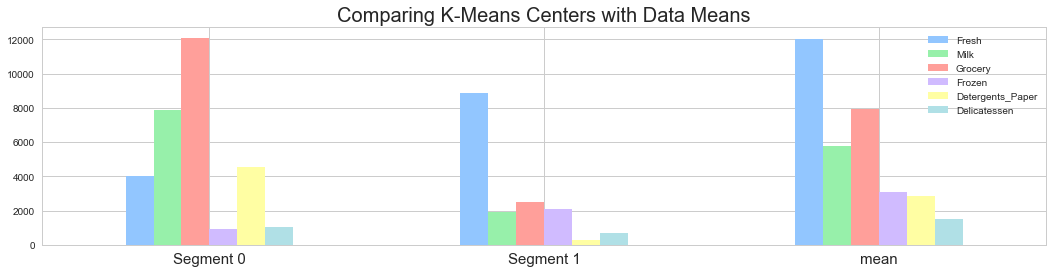

In [69]:
hide_code
true_centers = true_centers.append(data.describe().ix['mean'])
true_centers.plot(kind = 'bar', figsize = (18, 4))
plt.xticks(rotation=0, fontsize=15)
plt.title('Comparing K-Means Centers with Data Means', fontsize=20);

In [70]:
hide_code
print ("Gaussian Mixture Model")
# Inverse transform the centers
log_centers2 = pca.inverse_transform(centers2)

# Exponentiate the centers
true_centers2 = np.exp(log_centers2)

# Display the true centers
segments2 = ['Segment {}'.format(i) for i in range(0,len(centers2))]
true_centers2 = pd.DataFrame(np.round(true_centers2), columns = data.keys())
true_centers2.index = segments2
display(true_centers2)

Gaussian Mixture Model


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3812.0,6414.0,9838.0,942.0,3242.0,886.0
Segment 1,9606.0,2068.0,2675.0,2195.0,331.0,752.0


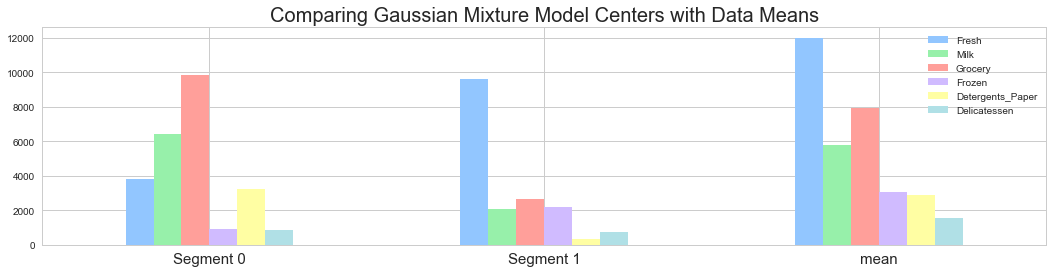

In [71]:
hide_code
true_centers2 = true_centers2.append(data.describe().ix['mean'])
true_centers2.plot(kind = 'bar', figsize = (18, 4))
plt.xticks(rotation=0, fontsize=15)
plt.title('Comparing Gaussian Mixture Model Centers with Data Means', fontsize=20);

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. 

*What set of establishments could each of the customer segments represent?*  
### Answer 8
`'Fresh', 'Milk', 'Grocery', 'Detergents_Paper'` are perfect indicators:

 - `'Detergents_Paper', 'Grocery', 'Milk'` are higher than the mean for Retail and less than the mean for HoReCa (Hotel/Restaurant/Cafe);
 - `'Fresh'` has the higher level for HoReCa than for Retail. 

K-means:

- Segment 1: HoReCa (Hotel/Restaurant/Cafe)
- Segment 0: Retail

Gaussian Mixture Model:

- Segment 1: HoReCa (Hotel/Restaurant/Cafe)
- Segment 0: Retail

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*
### Answer 9
The customers C0 and C1 are in Retail, C2 - in HoReCa (Hotel/Restaurant/Cafe). 

My guesses in the beginning of the project about the segment for each customer are in line with the predictions.

In [116]:
hide_code
print ("K-Means")
# Display the predictions
for i, pred in enumerate(sample_preds):
    print ("Sample point", i, "predicted to be in Cluster", pred)
    print ('The distance between sample point {} and center of Cluster {}:'.format(i, pred))
    print (samples.iloc[i] - true_centers.iloc[pred]);

K-Means
Sample point 0 predicted to be in Cluster 0
The distance between sample point 0 and center of Cluster 0:
Fresh               22368.0
Milk                28523.0
Grocery              9915.0
Frozen               4202.0
Detergents_Paper     -224.0
Delicatessen        15487.0
dtype: float64
Sample point 1 predicted to be in Cluster 0
The distance between sample point 1 and center of Cluster 0:
Fresh               12160.0
Milk                -3670.0
Grocery             -4509.0
Frozen               -751.0
Detergents_Paper     -558.0
Delicatessen         -979.0
dtype: float64
Sample point 2 predicted to be in Cluster 1
The distance between sample point 2 and center of Cluster 1:
Fresh               5409.0
Milk               -1094.0
Grocery              568.0
Frozen             -1603.0
Detergents_Paper    -194.0
Delicatessen        -163.0
dtype: float64


In [117]:
hide_code
print ("Gaussian Mixture Model")
# Display the predictions
for i, pred in enumerate(sample_preds2):
    print ("Sample point", i, "predicted to be in Cluster", pred)
    print ('The distance between sample point {} and center of Cluster {}:'.format(i, pred))
    print (samples.iloc[i] - true_centers.iloc[pred]);

Gaussian Mixture Model
Sample point 0 predicted to be in Cluster 0
The distance between sample point 0 and center of Cluster 0:
Fresh               22368.0
Milk                28523.0
Grocery              9915.0
Frozen               4202.0
Detergents_Paper     -224.0
Delicatessen        15487.0
dtype: float64
Sample point 1 predicted to be in Cluster 0
The distance between sample point 1 and center of Cluster 0:
Fresh               12160.0
Milk                -3670.0
Grocery             -4509.0
Frozen               -751.0
Detergents_Paper     -558.0
Delicatessen         -979.0
dtype: float64
Sample point 2 predicted to be in Cluster 1
The distance between sample point 2 and center of Cluster 1:
Fresh               5409.0
Milk               -1094.0
Grocery              568.0
Frozen             -1603.0
Detergents_Paper    -194.0
Delicatessen        -163.0
dtype: float64


## Conclusion
In this final section, we will investigate ways that we can make use of the clustered data. First, we will consider how the different groups of customers, the **customer segments**, may be affected differently by a specific delivery scheme. Next, we will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, we will compare the **customer segments** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

*How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
### Answer 10
If we reduce the delivery frequency for Retail it's possible to have a positive reaction: they do not order a lot of fresh food, it can reduce the transport cost, and their spending values are more predictable and regular. But some reactions could be negative: many supermarkets try to minimize inventory to save cost. 
The customers in HoReCa (Hotel/Restaurant/Cafe) can react positively if they have enough places for saving food. But a negative reaction also can be: some of them do not have enough space for saving, but they need fresh food for their business. 
For both segments, a negative effect is possible. Only an A/B test can detect if actually true.

We can run the A/B test with randomly selected samples for each cluster. It is possible to have absolutely different tendencies in the test results. One segment could have the significant effect, another segment could not demonstrate it. Their spending habits are not similar. If we mixed them we could lose information about the real effect.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a **customer segment** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a **customer segment** to determine the most appropriate delivery service.  

*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
### Answer 11
There are several ways for using and improving analytic predictions for labels:

- the clustering algorithms K-Means and GMMs updated for the new data points to include them into the certain clusters;
- supervised learning algorithms to detect differences between clusters, cluster labels can be just a target in the model predictions for new data points.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Let's see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, we will find the sample points are circled in the plot, which will identify their labeling.

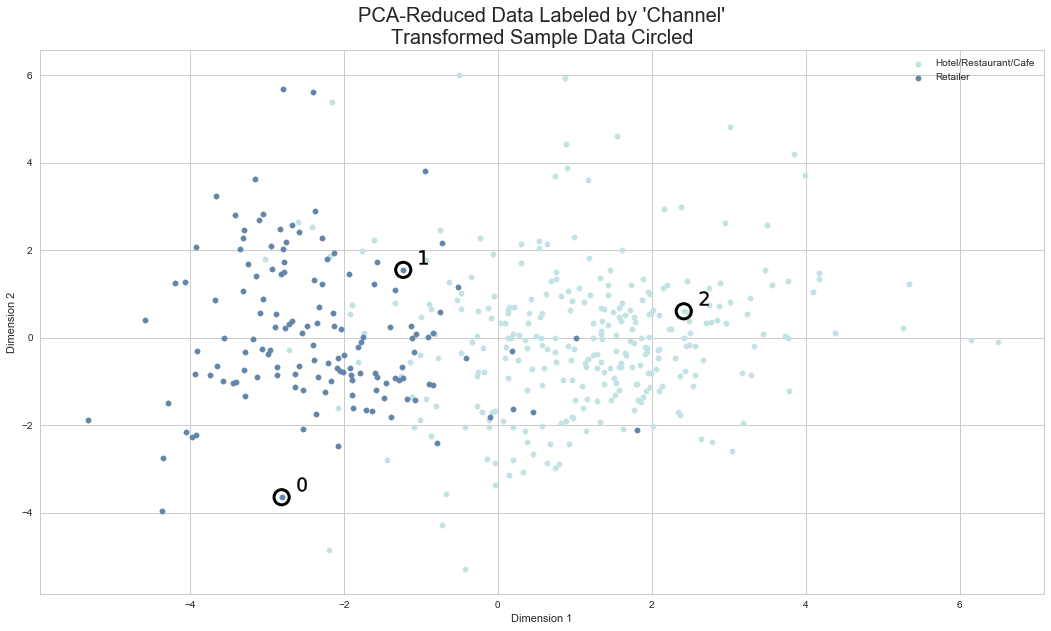

In [79]:
hide_code
# Display the clustering results based on 'Channel' data
channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*
### Answer 12
The number of clusters is consistent with the underlying distribution so both clustering algorithms work enough well. As we can see the K-Means simplicity does not affect the efficiency in this case.  

The customer segments classified as purely "Retailers" or "Hotels/"Restaurants/Cafes" on the left side and on the right side accordingly.

The algorithmic classification in the majority of cases is in line with the real results. We should note that for both algorithms borders of clusters are more clearly detectable.

Differences between actual and algorithmic classification may indicate a lack of the number of clusters for this market. Perhaps it needs a greater number to detect spending habits.

In [90]:
hide_code
channel_data = pd.read_csv("customers.csv")
channel_data = channel_data.drop(channel_data.index[outliers]).reset_index(drop = True)
# Might need to switch around the 0 and 1, based on the cluster seed
df = np.where(channel_data['Channel'] == 2, 0, 1)

print ("K-Means")
print ("Percentage of correctly classified customers: {:.2%}".format(sum(df == preds)/float(len(preds))))
print ("\nGaussian Mixture Model")
print ("Percentage of correctly classified customers: {:.2%}".format(sum(df == preds2)/float(len(preds2))))

K-Means
Percentage of correctly classified customers: 88.97%

Gaussian Mixture Model
Percentage of correctly classified customers: 85.75%


### Reflections

It would be interesting to repeat the steps of this project in R and compare the results.

In the future, I would like to try animation for clustering algorithms to compare the borders of clusters with real data labels in moving with different numbers of clusters. 